In [23]:
!ls -la workflows

total 176
drwxr-xr-x 1 amin 197121      0 Dec 26  2018 .
drwxr-xr-x 1 amin 197121      0 Apr 25 09:17 ..
-rw-r--r-- 1 amin 197121  12520 Oct 26  2015 L.txt
-rw-r--r-- 1 amin 197121   6402 Oct 26  2015 M.txt
-rw-r--r-- 1 amin 197121   4313 Oct 26  2015 S.txt
-rw-r--r-- 1 amin 197121 134048 Oct 26  2015 XXL.txt


# Loading the workflows and creating the resources

In [24]:
from Definitions.WorkflowReader.reader import read_jobs
from Definitions.Resources import CostAwareResources
BW = 1e50

wfs = read_jobs('workflows/S.txt')
resources = CostAwareResources([1, 1, 2], [1, 1, 3], [15, 15, 15], BW)
wfs

{'Mine_10': <Definitions.Graph.Graph at 0x5658da0>,
 'Mine_35': <Definitions.Graph.Graph at 0x5712908>,
 'CyberShake': <Definitions.Graph.Graph at 0x5712898>,
 'Epigenomics': <Definitions.Graph.Graph at 0x5712c88>,
 'Inspiral': <Definitions.Graph.Graph at 0x57b6400>,
 'Montage': <Definitions.Graph.Graph at 0x57b6e48>,
 'Sipht': <Definitions.Graph.Graph at 0x57cf278>}

In [9]:
import copy

wf1 = copy.deepcopy(wfs['Mine_10'])
wf1.name = 'g1'
wf2 = copy.deepcopy(wfs['Mine_10'])
wf2.name = 'g2'

11 , 1 , 4 , 7 , 12 
0 , 2.5 , 10.5 , 17.5 , 25.0 
0.0 , 10.5 , 17.5 , 21.5 , 25.0 
3 
2.5 
8.5 
10 , 2 , 5 , 8 , 6 , 9 
0 , 2.5 , 8.5 , 16.0 , 17.5 , 22.0 
2.5 , 8.5 , 16.0 , 17.0 , 22.0 , 25.0 


C:\Users\amin\Anaconda3\envs\micasense\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  if __name__ == '__main__':


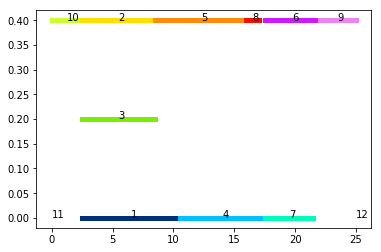

In [58]:
from Scheduler.BHEFT import schedule
wf = wfs['Mine_10']
schedule(wf, resources, 10)
show_schedule(wf)

In [59]:
resources.plan_cost

9

## BHEFT

In [13]:
import math
import Scheduler.HEFT
import Definitions.Resources

g, arrival_time = wf2, 30

# resources
budget = 100
upward_rank_is_calculated = False
priority_list=None

if not upward_rank_is_calculated:
    g.upward_rank(g.startID, resources.average_power, resources.bandwidth)
if priority_list is None:
    priority_list = Scheduler.HEFT.list_of_task_id_on_upward_rank(g)

sum_budget_remaining = 0
for i in range(0, resources.len):
    sum_budget_remaining += resources.price[i] / (resources.timeslot[i] * resources.power[i])
sum_budget_allocated = 0
average_price_of_computation = sum_budget_remaining / resources.len

sum_weight = math.fsum(map(lambda t: t.weight, g.tasks.values()))
sum_budget_remaining = average_price_of_computation * sum_weight
for tId in priority_list:
    est_best, eft_best, runtime_on_resource_best, place_id_best, resource_id_best, cost_best = \
        -1, -1, -1, -1, -1, -1
    sab_k = budget - sum_budget_allocated - sum_budget_remaining
    ctb_k = g.tasks[tId].weight * average_price_of_computation
    if sab_k >= 0 and sum_budget_remaining != 0:
        ctb_k += sab_k + ctb_k * sab_k / sum_budget_remaining
    affordable_found = False
    for r in range(0, resources.len):
        start_time, eft, runtime_on_resource, place_id, cost = resources.calculate_eft_and_cost(
            g.tasks[tId], r, arrival_time=arrival_time)
        if (not affordable_found and cost <= ctb_k) or (
                affordable_found and cost <= ctb_k and eft < eft_best) or (
            not affordable_found and sab_k >= 0 and (eft < eft_best or eft_best == -1)) or(
            not affordable_found and sab_k < 0 and (cost < cost_best or cost_best == -1)
        ):
            if cost <= ctb_k:
                affordable_found = True
            est_best, eft_best, runtime_on_resource_best, place_id_best, resource_id_best, cost_best = \
                start_time, eft, runtime_on_resource, place_id, r, cost
            continue

    task_schedule = Definitions.Resources.TaskSchedule(g.tasks[tId], est_best, runtime_on_resource_best, eft_best,
                                                       resource_id_best)
    sum_budget_remaining -= g.tasks[tId].weight * average_price_of_computation
    sum_budget_allocated += cost_best
    resources.schedule(task_schedule, place_id_best)

3 , 7 , 12 
45.0 , 56.0 , 66.0 
51.0 , 60.0 , 66.0 
11 , 10 , 2 , 4 , 8 
30 , 30.0 , 35.0 , 49.0 , 58.5 
30.0 , 35.0 , 47.0 , 56.0 , 60.5 
1 , 5 , 6 , 9 
45.0 , 51.0 , 58.5 , 63.0 
49.0 , 58.5 , 63.0 , 66.0 


C:\Users\amin\Anaconda3\envs\micasense\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  if __name__ == '__main__':


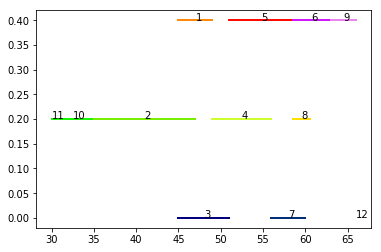

In [17]:
show_schedule(g)

In [15]:
resources.show_schedule('g2')

3 , 7 , 12 
45.0 , 56.0 , 66.0 
51.0 , 60.0 , 66.0 
11 , 10 , 2 , 4 , 8 
30 , 30.0 , 35.0 , 49.0 , 58.5 
30.0 , 35.0 , 47.0 , 56.0 , 60.5 
1 , 5 , 6 , 9 
45.0 , 51.0 , 58.5 , 63.0 
49.0 , 58.5 , 63.0 , 66.0 


[([3, 7, 12], [45.0, 56.0, 66.0], [51.0, 60.0, 66.0]),
 ([11, 10, 2, 4, 8],
  [30, 30.0, 35.0, 49.0, 58.5],
  [30.0, 35.0, 47.0, 56.0, 60.5]),
 ([1, 5, 6, 9], [45.0, 51.0, 58.5, 63.0], [49.0, 58.5, 63.0, 66.0])]

In [76]:
if not upward_rank_is_calculated:
    g.upward_rank(g.startID, resources.average_power, resources.bandwidth)
if priority_list is None:
    priority_list = Scheduler.HEFT.list_of_task_id_on_upward_rank(g)

In [80]:
# for tid in priority_list:
tid = 10
for r in range(0, resources.len):
        start_time, eft, runtime_on_resource, place_id, cost = resources.calculate_eft_and_cost(
            g.tasks[tid], r)
        print(start_time, eft, runtime_on_resource, place_id, cost, r, sep='\t')

25.0	30.0	5.0	-1	0.0	0
8.5	13.5	5.0	1	0.0	1
25.0	27.5	2.5	-1	0.0	2


In [75]:
wf.tasks[3].predecessor

{10: 3000.0}

In [77]:
priority_list


[11, 10, 2, 1, 3, 5, 4, 6, 7, 8, 9, 12]

In [26]:
bschedule(wf, resources, 100)


## Show Schedule method

In [16]:
from matplotlib import pyplot as plt
import numpy as np

def show_schedule(graph):
    sched = resources.show_schedule(graph.name)

    num_plots = sum([len(item[0]) for item in sched])
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])


    for i, entry in enumerate(sched):
        name = entry[0]
        est = entry[1]
        eft = entry[2]
        for j in range(len(est)):
    #         print(i, est[j], eft[j])
            plt.plot([est[j], eft[j]], [i/5, i/5], linewidth=2, label=name[j])
            plt.text((est[j] + eft[j]) / 2, i/5 , name[j])
    # plt.legend()
    plt.show()

### calculating resource cost

In [19]:
class a (object):
    pass
def new(est, eft):
    x = a()
    x.EST = est
    x.EFT = eft
    return x

In [20]:
timeslot = 5
tasks_in_resource = []
tasks_in_resource.append(new(2, 6))
tasks_in_resource.append(new(6, 7))
tasks_in_resource.append(new(13, 17))
tasks_in_resource.append(new(20, 27))
tasks_in_resource.append(new(33, 36))

In [21]:
startof = [x.EST for x in tasks_in_resource]
endof = [x.EFT for x in tasks_in_resource]

timeslot_start = min(startof)
last_finish_time = max(endof)
current_task_id = 0

rent_periods = []

while timeslot_start < last_finish_time:
    task_len = endof[current_task_id] - timeslot_start
    time_slot_finish = endof[current_task_id] + (timeslot - (task_len % timeslot)) % timeslot
    current_task_id += 1
    if current_task_id >= len(startof):
        rent_periods.append((timeslot_start, time_slot_finish))
        break
    if startof[current_task_id] <= time_slot_finish:
        pass
    else:
        rent_periods.append((timeslot_start, time_slot_finish))
        timeslot_start = startof[current_task_id]
print(rent_periods)

[(2, 7), (13, 18), (20, 30), (33, 38)]


In [22]:
cost = 0
for rp in rent_periods:
    cost += (rp[1] - rp[0]) / timeslot
cost

5.0

In [43]:
start = 10
end = 16
end + (timeslot - ((end - start) % timeslot)) % timeslot

20

### Calculating upward rank and sorting:

In [70]:
m10 = wfs['Mine_10']
m10.upward_rank(m10.startID, resources.average_power, resources.bandwidth)
tasks = [(m10.tasks[t].id, m10.tasks[t].upward_rank) for t in m10.tasks]
tasks.sort(key=lambda x: x[1])
tasks[::-1]

[(11, 43.666666666666664),
 (10, 43.666666666666664),
 (2, 35.33333333333333),
 (1, 33.0),
 (3, 29.333333333333332),
 (4, 23.666666666666668),
 (5, 22.333333333333332),
 (6, 17.0),
 (7, 11.666666666666666),
 (8, 6.333333333333333),
 (9, 4.0),
 (12, 0.0)]